In [1]:
from tensorflow.keras import datasets , layers , models
import tensorflow as tf
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report


2025-06-20 17:22:36.001608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 17:22:36.280817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750436556.385514   94052 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750436556.414468   94052 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750436556.664995   94052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
else:
    print("No GPU found, using CPU.")


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1750436585.342670   94052 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
batch_size = 64
num_classes = 10
epochs = 100
data_augmentation = False

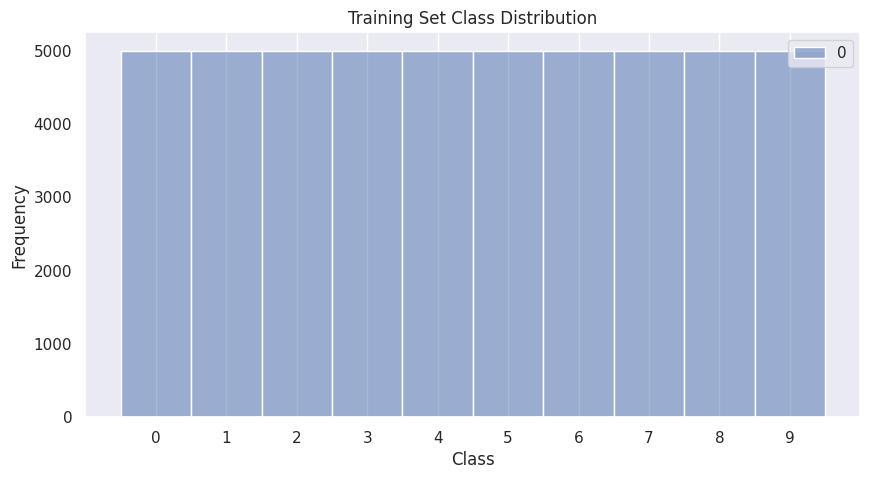

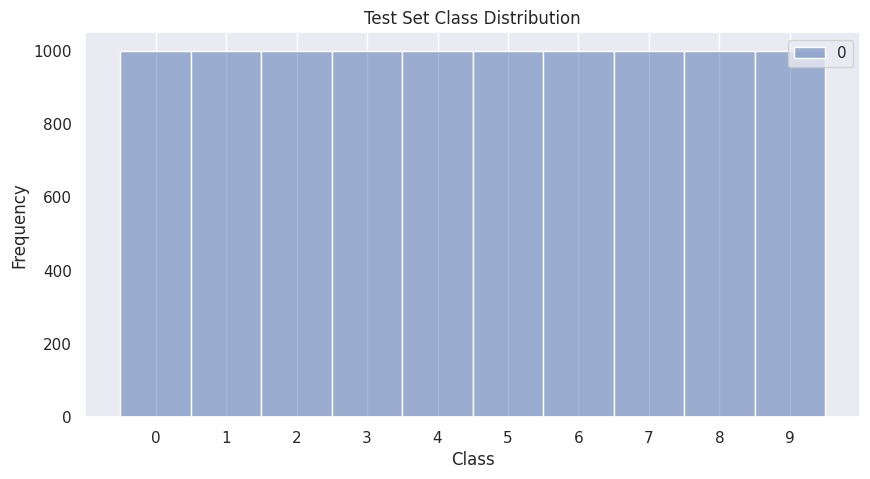

In [5]:
# make histograms of the classes
sns.set(style='darkgrid', palette='deep')
def plot_histogram(y, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(y, bins=np.arange(11) - 0.5, kde=False)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(10))
    plt.grid(axis='y')
    plt.show()
plot_histogram(y_train, 'Training Set Class Distribution')
plot_histogram(y_test, 'Test Set Class Distribution')


In [6]:
x_train = X_train.astype('float32') / 255.0
x_test = X_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [7]:
def create_model():
    return models.Sequential([
        layers.BatchNormalization(input_shape=(32, 32, 3)),
        
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
model_A = create_model()
model_A.summary()

/mnt/c/Users/kkiko/Desktop/CAA/FracGradient/.venv/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 918,358 (3.50 MB)

 Trainable params: 918,352 (3.50 MB)

 Non-trainable params: 6 (24.00 B)

In [8]:
model_A.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
import os
import json
file_exists = os.path.exists('models/ciphar10_model_A.h5')
if file_exists:
    print("Loading existing model A...")
    model_A.load_weights('models/ciphar10_model_A.h5')
    history_A = json.load(open('models/cifar10_history_A.json', 'r'))
    print("Model A loaded successfully.")
else:
    history_A = None
    if data_augmentation:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        datagen.fit(x_train)
        history_A = model_A.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            steps_per_epoch=x_train.shape[0] // batch_size)
    else:
        history_A = model_A.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test))

Epoch 1/100


I0000 00:00:1750436591.717938   94634 service.cc:152] XLA service 0x75549800fae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750436591.717979   94634 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-06-20 17:23:11.790584: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750436591.998620   94634 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-20 17:23:12.801631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2722_0', 96 bytes spill stores, 96 bytes spill loads

2025-06-20 17:23:13.077430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

 35/782 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1974 - loss: 3.3322

I0000 00:00:1750436597.664545   94634 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/782 ━━━━━━━━━━━━━━━━━━━━ 3:40 362ms/step - accuracy: 0.2932 - loss: 2.9455

2025-06-20 17:23:21.050192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2722', 4 bytes spill stores, 4 bytes spill loads

2025-06-20 17:23:24.450655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 92 bytes spill stores, 92 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.4173 - loss: 2.4324 - val_accuracy: 0.5479 - val_loss: 1.7263
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6206 - loss: 1.5266 - val_accuracy: 0.6601 - val_loss: 1.3792
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6605 - loss: 1.3836 - val_accuracy: 0.6991 - val_loss: 1.2904
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6926 - loss: 1.3149 - val_accuracy: 0.7035 - val_loss: 1.2858
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7004 - loss: 1.3038 - val_accuracy: 0.7077 - val_loss: 1.2805
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7128 - loss: 1.2802 - val_accuracy: 0.7137 - val_loss: 1.2713
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7161 - loss: 1.2684 - val_accuracy: 0.7310 - val_loss: 1.2389
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7184 - loss: 1.2697 - val_accuracy: 0.71

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


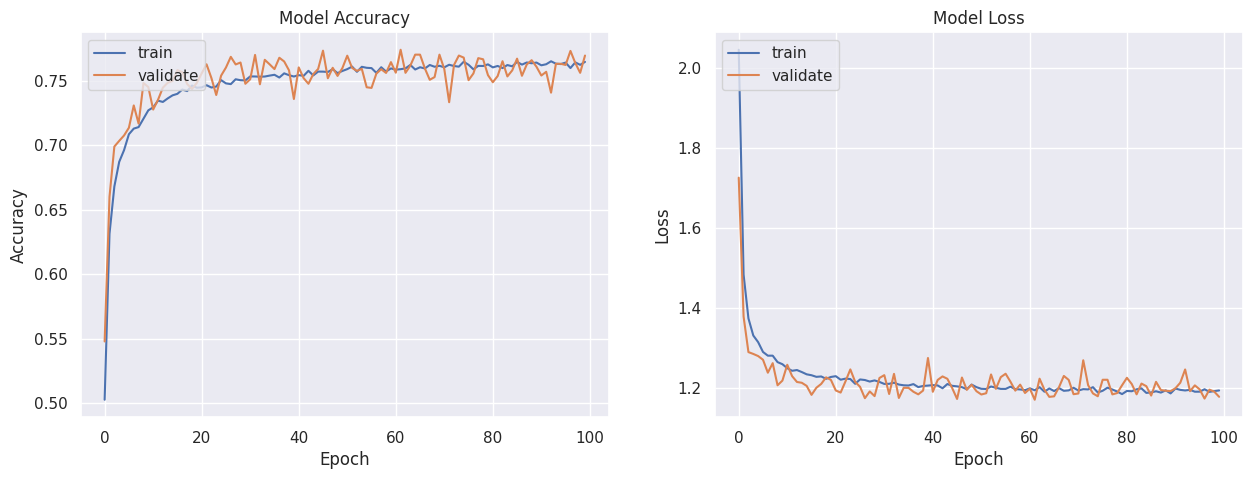

In [10]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history_A.history.keys()) # type: ignore
plotmodelhistory(history_A)

In [11]:
# evaluate the model
test_loss, test_acc = model_A.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

2025-06-20 17:27:54.220950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 92 bytes spill stores, 92 bytes spill loads



313/313 - 2s - 5ms/step - accuracy: 0.7697 - loss: 1.1787

Test accuracy: 0.7696999907493591
Test loss: 1.1786975860595703


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Normalized confusion matrix


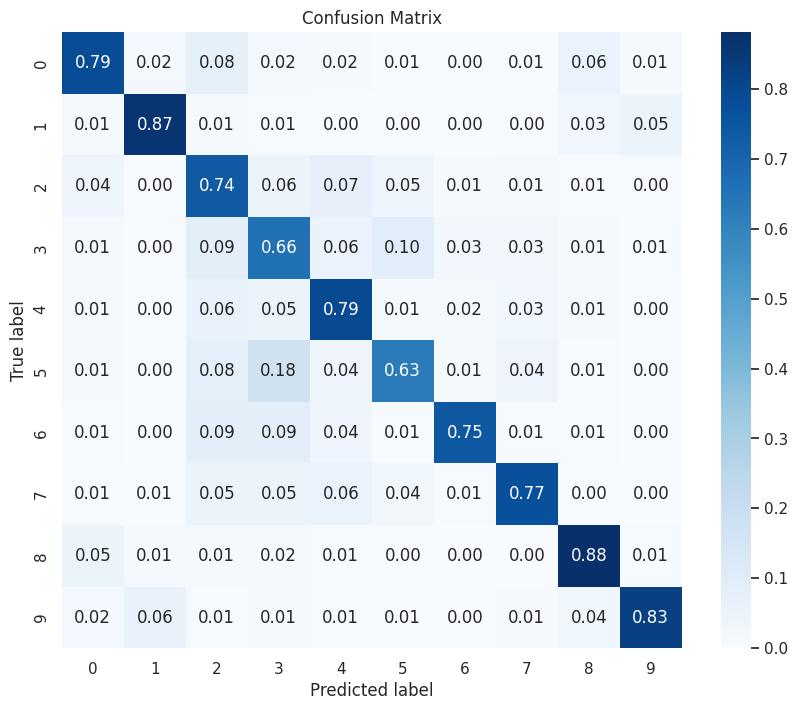

In [12]:
# confusion matrix
y_pred = model_A.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # type: ignore
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
cmap = sns.color_palette("Blues", as_cmap=True)
plot_confusion_matrix(cm, classes=[str(i) for i in range(num_classes)], normalize=True)

In [13]:
# classification report
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.89      0.87      0.88      1000
           2       0.60      0.74      0.66      1000
           3       0.57      0.66      0.61      1000
           4       0.72      0.79      0.76      1000
           5       0.74      0.63      0.68      1000
           6       0.90      0.75      0.82      1000
           7       0.84      0.77      0.80      1000
           8       0.84      0.88      0.86      1000
           9       0.90      0.83      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



In [14]:
# save the model
model_A.save('models/cifar10_model_A.h5')
# Save the history
if history_A is not None:
    import json
    with open('models/cifar10_history_A.json', 'w') as f:
        json.dump(history_A.history, f)
else:
    print("No history to save for model A.")

In [29]:
from ciphar10.optimizer import FracOptimizer, alpha_function

In [30]:
model_B = create_model()
model_B.summary()

/mnt/c/Users/kkiko/Desktop/CAA/FracGradient/.venv/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 918,358 (3.50 MB)

 Trainable params: 918,352 (3.50 MB)

 Non-trainable params: 6 (24.00 B)

In [31]:
import tensorflow as tf
from tensorflow.keras.optimizers import Optimizer
import numpy as np
import sys

@tf.function
def alpha_function(norm_GradCost, beta):
    """
    Computes the alpha value based on the norm of the gradient cost.
    """
    return 1.0 - (2.0 / np.pi) * tf.math.atan(norm_GradCost * beta)

class FracOptimizer(Optimizer):
    """
    A custom optimizer implementing a fractional gradient approach.

    This optimizer uses a dynamic alpha value, determined by the `alpha_function`,
    to modify the gradient updates based on the previous gradient's norm.
    """
    def __init__(self, learning_rate=0.001, beta=0.9, alpha_func=alpha_function, name="FracOptimizer", **kwargs):
        """
        Initializes the FracOptimizer.

        Args:
            learning_rate: A float, a `tf.Variable`, or a `tf.keras.optimizers.schedules.LearningRateSchedule`.
            beta: A float, parameter for the alpha function.
            alpha_func: A callable function that computes alpha. Defaults to `alpha_function`.
            name: Optional name for the optimizer.
            **kwargs: Keyword arguments for the base `Optimizer` class.
        """
        super().__init__(learning_rate=learning_rate,name=name, **kwargs)
        
        self.beta = beta
        self.alpha_func = alpha_func
        tf.print(f"FracOptimizer '{self.name}' initialized!")

    def build(self, var_list):
        """
        Builds the optimizer's state variables (slots).

        Args:
            var_list: The list of model variables to optimize.
        """
        self.prev_weights = []
        self.prev_grads = []

        for i, var in enumerate(var_list):
            self.prev_weights.append(
                self.add_variable_from_reference(
                    reference_variable=var, 
                    name=f"prev_weight_{i}", 
                    initializer="zeros"
                )
            )
            self.prev_grads.append(
                self.add_variable_from_reference(
                    reference_variable=var, 
                    name=f"prev_grad_{i}",
                    initializer="zeros"
                )
            )
        
        super().build(var_list) 

   
    def update_step(self, gradient, variable, learning_rate):
            """
            Applies a single optimization step on a given variable.
            Performs standard SGD on the first iteration, then fractional gradient.

            Args:
                gradient: The gradient of the loss with respect to the variable.
                variable: The variable to be updated.
                learning_rate: The current learning rate.
            """
            variable_index = self._get_variable_index(variable) 

            prev_weight = self.prev_weights[variable_index]
            prev_grad = self.prev_grads[variable_index]

            lr = tf.cast(learning_rate, variable.dtype) 

            is_first_iteration = tf.equal(self._iterations, 0)

            def standard_sgd_update():
                self.assign_sub(variable, lr * gradient)
                
            def fractional_gradient_update():
                norm_grad = tf.norm(prev_grad)
                alpha = self.alpha_func(norm_grad, self.beta)

                diff = tf.abs(variable - prev_weight)
        
                gamma_val = tf.math.exp(tf.math.lgamma(2.0 - alpha))
                frac_grad = prev_grad * tf.pow(diff + tf.keras.backend.epsilon(), 1.0 - alpha) / gamma_val

                self.assign_sub(variable, lr * frac_grad)


            # Use tf.cond to execute the appropriate update based on the iteration
            tf.cond(is_first_iteration, standard_sgd_update, fractional_gradient_update)
            self.assign(prev_weight, variable)
            self.assign(prev_grad, gradient)


    def get_config(self):
        """
        Returns the configuration of the optimizer.
        """
        config = super().get_config()
        config.update({
            "learning_rate": self._get_hyper("learning_rate"), # Use _get_hyper to retrieve learning rate
            "beta": self.beta,
            # Note: Serializing callables (like alpha_func) directly is complex.
            # Here, we store the function's name. If you load a saved model,
            # you'll need to re-map this string name back to the actual function.
            "alpha_func": self.alpha_func.__name__
        })
        return config

In [32]:
model_B.compile(optimizer=FracOptimizer(learning_rate=0.01, beta=0.01, alpha_func=alpha_function),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

FracOptimizer 'FracOptimizer' initialized!


In [33]:
history_B = None
if False:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    history_B = model_B.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          steps_per_epoch=x_train.shape[0] // batch_size)
else:
    history_B = model_B.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          verbose=1)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s -69336us/step - accuracy: 0.2327 - loss: 3.0804 - val_accuracy: 0.4360 - val_loss: 2.5604
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4108 - loss: 2.5964 - val_accuracy: 0.4875 - val_loss: 2.4043
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4705 - loss: 2.4450 - val_accuracy: 0.5178 - val_loss: 2.2832
Epoch 4/100
504/782 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.5007 - loss: 2.3388

IOStream.flush timed out


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5039 - loss: 2.3278 - val_accuracy: 0.5285 - val_loss: 2.2230
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5356 - loss: 2.2197 - val_accuracy: 0.5869 - val_loss: 2.0569
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5673 - loss: 2.1318 - val_accuracy: 0.5971 - val_loss: 2.0153
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5812 - loss: 2.0533 - val_accuracy: 0.6317 - val_loss: 1.9141
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6037 - loss: 1.9830 - val_accuracy: 0.6353 - val_loss: 1.8775
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6205 - loss: 1.9208 - val_accuracy: 0.6270 - val_loss: 1.8770
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6329 - loss: 1.8636 - val_accuracy: 0.6642 - val_loss: 1.7634
Epoch 11/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6457 - loss: 1.8068 - val_accuracy: 0.66

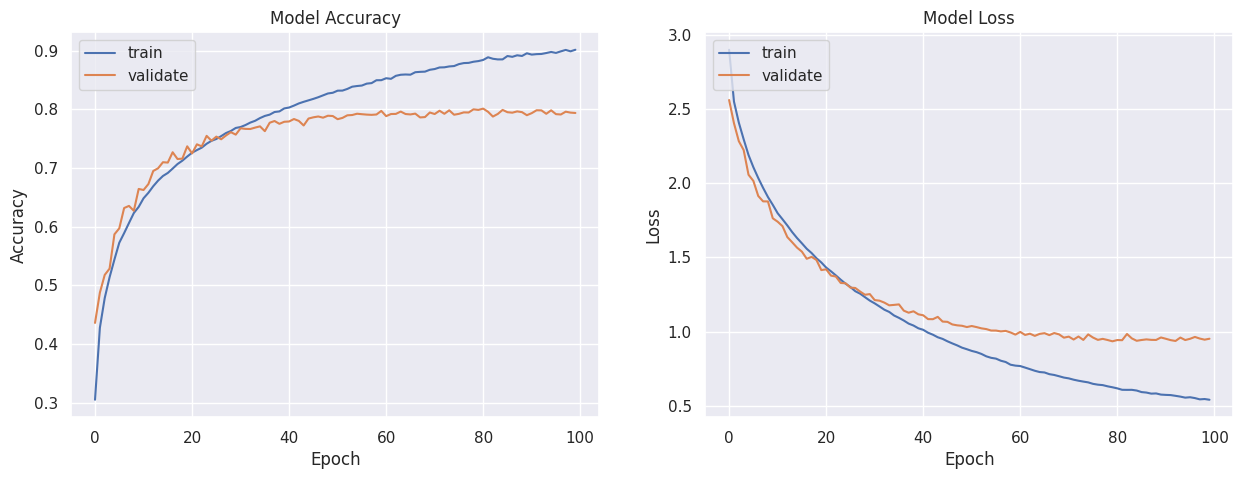

In [34]:
plotmodelhistory(history_B)

In [35]:
test_loss, test_acc = model_B.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 - 1s - 3ms/step - accuracy: 0.7936 - loss: 0.9519

Test accuracy: 0.7936000227928162
Test loss: 0.9519323110580444


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Normalized confusion matrix


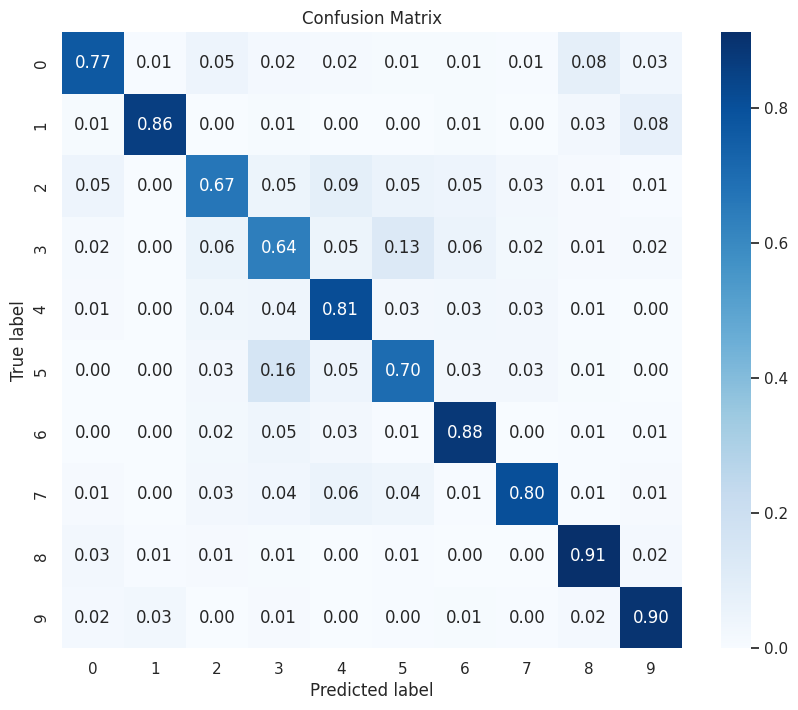

In [36]:
y_pred_B = model_B.predict(x_test)
y_pred_classes_B = np.argmax(y_pred_B, axis=1)  # type: ignore
y_true_B = np.argmax(y_test, axis=1)
cm_B = confusion_matrix(y_true_B, y_pred_classes_B)
plot_confusion_matrix(cm_B, classes=[str(i) for i in range(num_classes)], normalize=True)

In [37]:
report_B = classification_report(y_true_B, y_pred_classes_B, target_names=[str(i) for i in range(num_classes)])
print("Classification Report for Model B:\n", report_B)

Classification Report for Model B:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1000
           1       0.94      0.86      0.90      1000
           2       0.74      0.67      0.70      1000
           3       0.62      0.64      0.63      1000
           4       0.74      0.81      0.77      1000
           5       0.71      0.70      0.71      1000
           6       0.82      0.88      0.85      1000
           7       0.87      0.80      0.83      1000
           8       0.84      0.91      0.87      1000
           9       0.84      0.90      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



In [38]:
# save the model
model_B.save('models/cifar10_model_B.h5')
# Save the history
if history_B is not None:
    with open('models/cifar10_history_B.json', 'w') as f:
        json.dump(history_B.history, f)
else:
    print("No history to save for model B.")

AttributeError: 'FracOptimizer' object has no attribute '_get_hyper'